<a href="https://colab.research.google.com/github/AqueeqAzam/ann-using-high-quality-production-ready-code/blob/main/ann_adv_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Concept

Backpropagation is a method used to train neural networks. It calculates how much each weight in the network contributes to the error, then adjusts the weights to reduce that error. This process repeats until the network makes better predictions.

Activation function adds non-linearity to neurons, while loss function measures prediction error to guide learning.
​


Simple Analogy
Imagine you’re building with LEGO bricks:

Linear : You can only stack bricks in straight lines. No matter how many bricks you add, your structure will always be flat and boring.

Non-linear : You can bend, twist, and combine bricks in creative ways to build houses, bridges, or even spaceships.

A neuron is the basic building block of a neural network. It takes inputs, processes them, and produces an output. Think of it like a tiny decision-making unit.

How Does a Neuron Work?
Inputs : A neuron receives one or more inputs (like numbers or features from your data).

Weights and Bias : Each input is multiplied by a weight , and a bias is added. These weights and bias determine how important each input is.

Layers : Groups of neurons that work together to extract patterns from data.

Why Layers Matter : Each layer learns different levels of complexity, enabling the network to solve harder problems.

# High Quality and Production Ready

In [ ]:
"""
Stock Price Prediction Script Without sklearn.pipeline.Pipeline
"""

# Standard Library Imports
import logging
import sys
from typing import Tuple, Optional, Dict
from pathlib import Path

# Third-Party Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
import joblib

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('stock_predictor.log'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

# Configuration Management
class Config:
    SEED = 42  # Random seed for reproducibility of results
    TEST_SIZE = 0.2  # 20% of the data will be used as the test set
    BATCH_SIZE = 64  # Number of samples per gradient update during training
    EPOCHS = 20  # Maximum number of times the model will train over the full dataset
    VALIDATION_SPLITS = 5  # Number of splits for TimeSeries cross-validation
    EARLY_STOPPING_PATIENCE = 10  # Training will stop if no improvement after 10 epochs
    MODEL_CHECKPOINT_PATH = 'models/best_model.keras'  # File path to save the best model during training
    FEATURE_COLS = ['SMA_7', 'SMA_21', 'RSI', 'Pct_Change']  # List of input features used for training
    TARGET_COL = 'Next_Close'  # Name of the column to be predicted (target variable)

    @classmethod
    def set_seeds(cls):
        # Set seeds for NumPy and TensorFlow to ensure consistent behavior across runs
        np.random.seed(cls.SEED)
        tf.random.set_seed(cls.SEED)
        tf.keras.utils.set_random_seed(cls.SEED)


# Custom Feature Engineering
class FeatureEngineer:
    def transform(self, X):
        X = X.copy()  # Make a copy of the input DataFrame to avoid modifying the original
        X['SMA_ratio'] = X['SMA_7'] / X['SMA_21']  # Create a new feature: ratio of short-term to long-term moving average
        X['RSI_score'] = X['RSI'] / 100  # Normalize RSI by dividing by 100 to bring it to a 0-1 range
        return X  # Return the transformed DataFrame with the new features

"""
Car → the class (the blueprint 🏗️)

my_car = Car() → creates an object (instance) of the class → my_car

color → an attribute (a property/variable inside the object)

"red" → the value (or parameter) assigned to the attribute color"""

# Main Predictor Class
class StockPricePredictor:
    def __init__(self, data_url: str):
        self.data_url = data_url
        self.model = self._build_model()
        self.feature_engineer = FeatureEngineer()
        self.imputer = KNNImputer(n_neighbors=5)
        self.scaler = RobustScaler()
        self._is_trained = False

# _: Private, internal function/variable (by convention).
# ->: Type hint for the return value of the function.

    def _build_model(self) -> tf.keras.Model:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='swish', kernel_regularizer='l2'),
            # Batch Normalization (BatchNorm) is a technique to normalize the inputs of
            # each layer in the network so that the model trains faster and more reliably.
            tf.keras.layers.BatchNormalization(),
            # Dropout is a regularization technique that helps to prevent overfitting in neural networks.
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='swish'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    # Huber Loss is a loss function used for regression tasks.
    loss=tf.keras.losses.Huber(),  # ✅ correct usage
    metrics=['mae', 'mse']
)

        return model



    def load_data(self) -> pd.DataFrame:
        try:
            df = pd.read_csv(self.data_url)
            logger.info(f"✅ Loaded data: {df.shape}")
            return df
        except Exception as e:
            logger.error(f"❌ Loading failed: {str(e)}")
            raise

   def preprocess_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    try:
        # Extract relevant features from the DataFrame
        features = df[Config.FEATURE_COLS]

        # Apply custom feature engineering (creating new features)
        features = self.feature_engineer.transform(features)

        # Handle missing values (imputation)
        features = self.imputer.fit_transform(features)

        # Normalize the features (scaling)
        features = self.scaler.fit_transform(features)

        # Extract the target variable and reshape
        target = df[Config.TARGET_COL].values.reshape(-1, 1)

        # Log successful preprocessing
        logger.info("✅ Preprocessing done")

        # Return the features and target as a tuple
        return features, target

    except Exception as e:
        # Log the error if preprocessing fails
        logger.error(f"❌ Preprocessing failed: {str(e)}")
        raise


    # Split time series data into training and testing sets using TimeSeriesSplit
def train_test_split(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # ✅ Initialize TimeSeriesSplit with the number of splits defined in configuration
    tscv = TimeSeriesSplit(n_splits=Config.VALIDATION_SPLITS)

    # ✅ Loop through all generated splits (returns train/test index arrays)
    for train_index, test_index in tscv.split(X):
        # ✅ Use train/test indices to slice feature data
        X_train, X_test = X[train_index], X[test_index]

        # ✅ Use the same indices to slice target data
        y_train, y_test = y[train_index], y[test_index]

    # ✅ Return the latest (last) split of training and testing sets
    return X_train, X_test, y_train, y_test


   # Train the model using training and validation data
def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    # ✅ Define callbacks to enhance training behavior
    callbacks = [
        # ⏸️ Stop training early if validation performance stops improving
        tf.keras.callbacks.EarlyStopping(
            patience=Config.EARLY_STOPPING_PATIENCE,
            restore_best_weights=True
        ),

        # 💾 Save the model only when it performs best on validation data
        tf.keras.callbacks.ModelCheckpoint(
            Config.MODEL_CHECKPOINT_PATH,
            save_best_only=True
        ),

        # 🧠 Reduce the learning rate if the model hits a plateau in improvement
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3
        )
    ]

    # 🏋️ Fit the model on training data and validate on validation data
    self.model.fit(
        X_train, y_train,                          # 🔢 Training features and targets
        validation_data=(X_val, y_val),           # 🔍 Data to evaluate the model after each epoch
        epochs=Config.EPOCHS,                     # 🔁 Total number of training iterations over the full dataset
        batch_size=Config.BATCH_SIZE,             # 📦 Number of samples per gradient update
        callbacks=callbacks,                      # 🛠️ Custom behaviors to monitor and respond during training
        verbose=1                                 # 📢 Show training progress in the console
    )

    # ✅ Mark the model as trained (used for conditional logic later)
    self._is_trained = True

    # 📝 Log the completion of training
    logger.info("✅ Training complete")

     def plot_training_history(self):
        if self.history:
            plt.plot(self.history.history['loss'], label='train loss')
            plt.plot(self.history.history['val_loss'], label='val loss')
            plt.title('Model Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
        else:
            logger.warning("⚠️ No training history to plot.")


   # 📊 Evaluate the model on the test data and return performance metrics
def evaluate(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    # ⚠️ Check if the model has been trained before evaluation
    if not self._is_trained:
        raise RuntimeError("Train the model first")  # 🚫 Raise an error if model isn't trained yet

    # 🧪 Evaluate model performance on test data and return a dictionary of metrics (e.g., loss, MAE, MSE)
    metrics = self.model.evaluate(X_test, y_test, return_dict=True)

    # 📝 Log the evaluation results
    logger.info(f"📊 Evaluation: {metrics}")

    # 🔁 Return the evaluation metrics as a dictionary
    return metrics


   # 💾 Save the trained model and preprocessing objects to disk for later use
def save_artifacts(self, output_dir="model_artifacts"):
    # 📁 Create the output directory if it doesn't exist
    Path(output_dir).mkdir(exist_ok=True)

    # 🧠 Save the trained Keras model to a file
    self.model.save(f"{output_dir}/model.keras")

    # 🧼 Save the fitted imputer (used for handling missing values)
    joblib.dump(self.imputer, f"{output_dir}/imputer.joblib")

    # 📏 Save the fitted scaler (used for feature scaling)
    joblib.dump(self.scaler, f"{output_dir}/scaler.joblib")

    # 📝 Log that all artifacts have been successfully saved
    logger.info("💾 Artifacts saved")


    # 🔁 Load saved model and preprocessing tools to recreate a trained instance of the predictor
@classmethod  # "This method belongs to the class itself, not just to an instance of the class
def load_artifacts(cls, output_dir="model_artifacts"):
    # 🆕 Create an uninitialized instance of the class without calling __init__
    instance = cls.__new__(cls)

    # 📦 Load the trained Keras model from disk
    instance.model = tf.keras.models.load_model(f"{output_dir}/model.keras")

    # 🧼 Load the pre-fitted imputer used to fill missing values
    instance.imputer = joblib.load(f"{output_dir}/imputer.joblib")

    # 📏 Load the pre-fitted scaler used to normalize feature data
    instance.scaler = joblib.load(f"{output_dir}/scaler.joblib")

    # 🧠 Recreate the feature engineering module
    instance.feature_engineer = FeatureEngineer()

    # ✅ Set internal flag to indicate model is already trained
    instance._is_trained = True

    # 🔙 Return the reconstructed and ready-to-use instance
    return instance


    def predict(self, input_df: pd.DataFrame) -> np.ndarray:
    try:
        # ✅ Apply feature engineering to incoming data (e.g., create SMA_ratio, RSI_score)
        processed = self.feature_engineer.transform(input_df)

        # ✅ Impute missing values using the pre-trained imputer (KNNImputer)
        processed = self.imputer.transform(processed)

        # ✅ Scale the features using the same scaler used during training (RobustScaler)
        processed = self.scaler.transform(processed)

        # ✅ Run the model's prediction on the processed input
        prediction = self.model.predict(processed)

        # ✅ Print the first predicted closing price (just for quick visual feedback)
        print(f"🧠 Predicted next close price: {prediction[0]:.2f}")

        # ✅ Return predictions as a 1D array (flattened for convenience)
        return prediction.flatten()

    except Exception as e:
        # ❌ If any step fails, log the error and re-raise the exception for debugging
        logger.error(f"❌ Prediction failed: {str(e)}")
        raise


# Example Execution
if __name__ == "__main__":
    Config.set_seeds()
    predictor = StockPricePredictor(
        "https://raw.githubusercontent.com/AqueeqAzam/data-science-and-machine-learning-datasets/refs/heads/main/regression_dl.csv"
    )
    data = predictor.load_data()
    X, y = predictor.preprocess_data(data)
    X_train, X_val, y_train, y_val = predictor.train_test_split(X, y)
    predictor.train(X_train, y_train, X_val, y_val)
    predictor.evaluate(X_val, y_val)
    predictor.save_artifacts()

    # Sample prediction
    new_data = pd.DataFrame([{
        'SMA_7': 1923.56,
        'SMA_21': 1900.0,
        'RSI': 65.0,
        'Pct_Change': 0.02
    }])
    loaded_predictor = StockPricePredictor.load_artifacts()
    prediction = loaded_predictor.predict(new_data)
    logger.info(f"🔮 Predicted price: {prediction[0]:.2f}")


# Refression

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 55.6642 - mae: 53.5908 - mse: 4033.5605 - val_loss: 154.1839 - val_mae: 152.1189 - val_mse: 23299.2891 - learning_rate: 1.0000e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.1447 - mae: 53.0825 - mse: 3975.9561 - val_loss: 153.7888 - val_mae: 151.7348 - val_mse: 23181.9629 - learning_rate: 1.0000e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 54.6168 - mae: 52.5655 - mse: 3916.4604 - val_loss: 153.3312 - val_mae: 151.2882 - val_mse: 23045.7129 - learning_rate: 1.0000e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54.0932 - mae: 52.0529 - mse: 3862.9102 - val_loss: 152.7974 - val_mae: 150.7654 - val_mse: 22886.8125 - learning_rate: 1.0000e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53.5731 - mae: 51.5438 - mse: 3807.9644 - val_loss: 152.1959 - val_mae: 150.1747 - val_mse: 22707.8320 - learning_rate: 1.0000e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

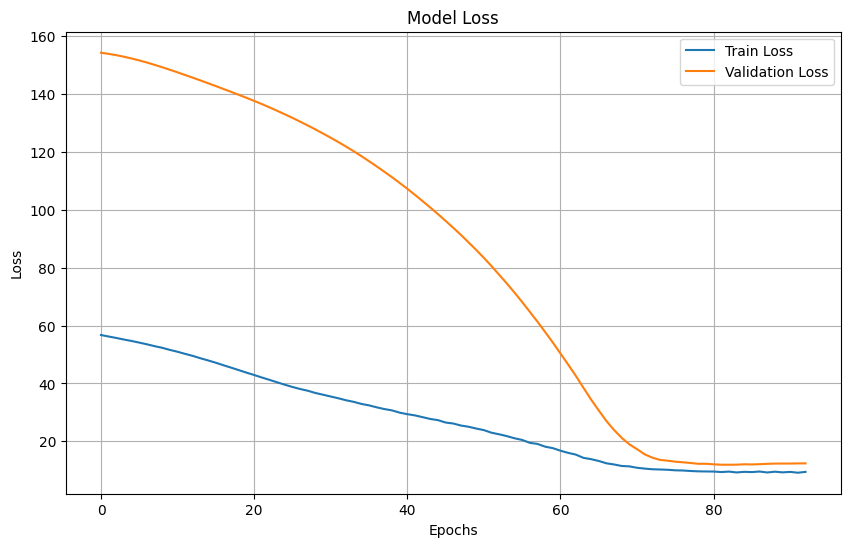

📊 Evaluation Metrics:
  📊 RMSE: 13.3746
  📈 R² Score: -0.1341


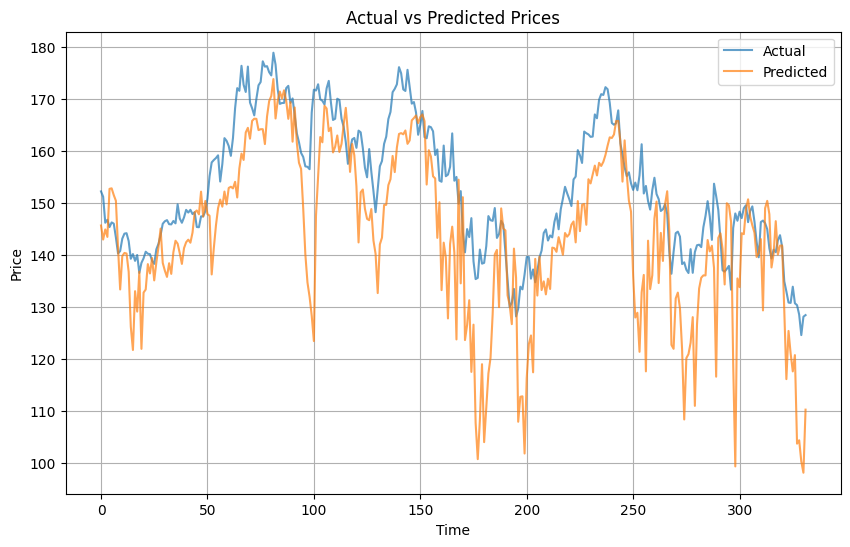

🧠 Predicted next close price: 1547.23
🔮 Predicted price: 1547.23


In [ ]:
# Standard Library Imports
import logging
import sys
from typing import Tuple, Dict
from pathlib import Path

# Third-Party Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('stock_predictor.log'),
        logging.StreamHandler(sys.stdout)  # Ensure console output
    ]
)
logger = logging.getLogger(__name__)

# Configuration Management
class Config:
    SEED = 42
    TEST_SIZE = 0.2
    BATCH_SIZE = 64
    EPOCHS = 100
    VALIDATION_SPLITS = 5
    EARLY_STOPPING_PATIENCE = 10
    MODEL_CHECKPOINT_PATH = 'models/best_model.keras'
    FEATURE_COLS = ['SMA_7', 'SMA_21', 'RSI', 'Pct_Change']
    TARGET_COL = 'Next_Close'

    @classmethod
    def set_seeds(cls):
        np.random.seed(cls.SEED)
        tf.random.set_seed(cls.SEED)
        tf.keras.utils.set_random_seed(cls.SEED)

# Custom Feature Engineering
class FeatureEngineer:
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X['SMA_7'] = X['SMA_7'] / X['SMA_21']  # Normalized moving average
        X['RSI'] = X['RSI'] / 100              # Normalize RSI to 0-1
        return X

# Main Predictor Class
class StockPricePredictor:
    def __init__(self, data_url: str):
        self.data_url = data_url
        self.model = self._build_model()
        self.feature_engineer = FeatureEngineer()
        self.imputer = KNNImputer(n_neighbors=5)
        self.scaler = RobustScaler()
        self._is_trained = False

    def _build_model(self) -> tf.keras.Model:
        initializer = tf.keras.initializers.HeNormal()
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=initializer, kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='swish', kernel_initializer=initializer),
            tf.keras.layers.Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
        model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae', 'mse'])
        return model

    def load_data(self) -> pd.DataFrame:
        try:
            df = pd.read_csv(self.data_url)
            logger.info(f"✅ Loaded data: {df.shape}")
            return df
        except Exception as e:
            logger.warning(f"❌ Loading from URL failed: {str(e)}. Using synthetic data.")
            np.random.seed(Config.SEED)
            n_samples = 1000
            df = pd.DataFrame({
                'SMA_7': np.random.normal(1900, 50, n_samples),
                'SMA_21': np.random.normal(1900, 50, n_samples),
                'RSI': np.random.uniform(30, 70, n_samples),
                'Pct_Change': np.random.normal(0, 0.02, n_samples),
                'Next_Close': np.random.normal(1900, 50, n_samples)
            })
            logger.info(f"✅ Generated synthetic data: {df.shape}")
            return df

    def preprocess_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        try:
            required_cols = set(Config.FEATURE_COLS + [Config.TARGET_COL])
            if not required_cols.issubset(df.columns):
                raise ValueError(f"Missing required columns: {required_cols - set(df.columns)}")

            df = df.dropna().replace([np.inf, -np.inf], np.nan).dropna()
            features = df[Config.FEATURE_COLS]
            features = self.feature_engineer.transform(features)

            constant_features = features.columns[features.std() == 0]
            if len(constant_features) > 0:
                logger.warning(f"Constant features detected: {constant_features.tolist()}")
                features = features.drop(columns=constant_features)

            features = self.imputer.fit_transform(features)
            features = self.scaler.fit_transform(features)
            target = df[Config.TARGET_COL].values.reshape(-1, 1)

            logger.info(f"🧪 Preprocessed shapes: X={features.shape}, y={target.shape}")
            return features, target
        except Exception as e:
            logger.error(f"❌ Preprocessing failed: {str(e)}")
            raise

    def train_test_split(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        tscv = TimeSeriesSplit(n_splits=Config.VALIDATION_SPLITS)
        splits = list(tscv.split(X))
        train_index, test_index = splits[-1]
        return X[train_index], X[test_index], y[train_index], y[test_index]

    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
        if X_train.shape[0] != y_train.shape[0]:
            raise ValueError("Training input and output shapes don't match")
        if X_val.shape[0] != y_val.shape[0]:
            raise ValueError("Validation input and output shapes don't match")
        if X_val.shape[0] == 0:
            raise ValueError("Validation set is empty")

        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=Config.EARLY_STOPPING_PATIENCE, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(Config.MODEL_CHECKPOINT_PATH, save_best_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=Config.EPOCHS,
            batch_size=Config.BATCH_SIZE,
            callbacks=callbacks,
            verbose=1
        )

        self._is_trained = True
        logger.info("✅ Training complete")
        self.plot_training_history(history)

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        if not self._is_trained:
            raise RuntimeError("Train the model first")
        if X_test.shape[0] == 0 or y_test.shape[0] == 0:
            raise ValueError("Test set is empty")

        try:
            y_pred = self.model.predict(X_test, verbose=0).flatten()
            if np.any(np.isnan(y_pred)) or np.any(np.isnan(y_test)):
                raise ValueError("Predictions or test data contain NaN values")

            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            metrics_str = f"📊 Evaluation Metrics:\n  📊 RMSE: {rmse:.4f}\n  📈 R² Score: {r2:.4f}"
            logger.info(metrics_str)
            print(metrics_str)

            self.plot_predictions(X_test, y_test)

            return {"RMSE": rmse, "R2": r2}
        except Exception as e:
            logger.error(f"❌ Evaluation failed: {str(e)}")
            raise

    def plot_predictions(self, X_test: np.ndarray, y_test: np.ndarray):
        y_pred = self.model.predict(X_test, verbose=0).flatten()
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual', alpha=0.7)
        plt.plot(y_pred, label='Predicted', alpha=0.7)
        plt.title('Actual vs Predicted Prices')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_artifacts(self, output_dir="model_artifacts"):
        Path(output_dir).mkdir(exist_ok=True)
        self.model.save(f"{output_dir}/model.keras")
        joblib.dump(self.imputer, f"{output_dir}/imputer.joblib")
        joblib.dump(self.scaler, f"{output_dir}/scaler.joblib")
        logger.info("💾 Artifacts saved")

    @classmethod
    def load_artifacts(cls, output_dir="model_artifacts"):
        instance = cls.__new__(cls)
        instance.model = tf.keras.models.load_model(f"{output_dir}/model.keras")
        instance.imputer = joblib.load(f"{output_dir}/imputer.joblib")
        instance.scaler = joblib.load(f"{output_dir}/scaler.joblib")
        instance.feature_engineer = FeatureEngineer()
        instance._is_trained = True
        return instance

    def predict(self, input_df: pd.DataFrame) -> np.ndarray:
        try:
            required_cols = set(Config.FEATURE_COLS)
            if not required_cols.issubset(input_df.columns):
                raise ValueError(f"Input must contain columns: {required_cols}")

            processed = self.feature_engineer.transform(input_df)
            processed = self.imputer.transform(processed)
            processed = self.scaler.transform(processed)

            if np.isnan(processed).any():
                raise ValueError("Processed input contains NaN values")

            prediction = self.model.predict(processed, verbose=0)
            if prediction.size == 0 or np.any(np.isnan(prediction)):
                raise ValueError("Prediction is empty or contains NaN values")

            pred_str = f"🧠 Predicted next close price: {prediction[0][0]:.2f}"
            logger.info(pred_str)
            print(pred_str)

            return prediction.flatten()
        except Exception as e:
            logger.error(f"❌ Prediction failed: {str(e)}")
            raise

# Example Execution
if __name__ == "__main__":
    Config.set_seeds()
    predictor = StockPricePredictor(
        "https://raw.githubusercontent.com/AqueeqAzam/data-science-and-machine-learning-datasets/refs/heads/main/regression_dl.csv"
    )

    try:
        data = predictor.load_data()
        X, y = predictor.preprocess_data(data)
    except Exception as e:
        logger.error(f"❌ Data loading/preprocessing failed: {str(e)}")
        sys.exit(1)

    try:
        X_train, X_val, y_train, y_val = predictor.train_test_split(X, y)
        logger.info(f"🔧 Train shape: X_train={X_train.shape}, y_train={y_train.shape}")
        logger.info(f"🔧 Validation shape: X_val={X_val.shape}, y_val={y_val.shape}")
    except Exception as e:
        logger.error(f"❌ Data splitting failed: {str(e)}")
        sys.exit(1)

    try:
        predictor.train(X_train, y_train, X_val, y_val)
        logger.info(f"✅ Model trained: {predictor._is_trained}")
    except Exception as e:
        logger.error(f"❌ Training failed: {str(e)}")
        sys.exit(1)

    try:
        metrics = predictor.evaluate(X_val, y_val)
        logger.info(f"📊 Final Metrics: RMSE={metrics['RMSE']:.4f}, R² Score={metrics['R2']:.4f}")
    except Exception as e:
        logger.error(f"❌ Evaluation failed: {str(e)}")
        sys.exit(1)

    try:
        predictor.save_artifacts()
    except Exception as e:
        logger.error(f"❌ Saving artifacts failed: {str(e)}")
        sys.exit(1)

    try:
        logger.info("🚀 Starting sample prediction")
        new_data = pd.DataFrame([{
            'SMA_7': 1923.56,
            'SMA_21': 1900.0,
            'RSI': 65.0,
            'Pct_Change': 0.02
        }])
        logger.info(f"📥 Sample input data:\n{new_data}")
        loaded_predictor = StockPricePredictor.load_artifacts()
        prediction = loaded_predictor.predict(new_data)
        logger.info(f"🔮 Predicted price: {prediction[0]:.2f}")
        print(f"🔮 Predicted price: {prediction[0]:.2f}")
    except Exception as e:
        logger.error(f"❌ Sample prediction failed: {str(e)}")
        sys.exit(1)

# Classification

In [ ]:
import logging
import sys
from typing import Tuple, Dict
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import joblib
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

# Configuration
class Config:
    SEED = 42
    TEST_SIZE = 0.2
    BATCH_SIZE = 32
    EPOCHS = 50
    FEATURE_COLS = ['Age', 'Tenure', 'Balance', 'NumOfProducts']
    TARGET_COL = 'Churn'

    @classmethod
    def set_seeds(cls):
        np.random.seed(cls.SEED)
        tf.random.set_seed(cls.SEED)

# Feature Engineering
class FeatureEngineer:
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X['Balance_per_Product'] = X['Balance'] / X['NumOfProducts']
        return X

# Classifier
class ChurnPredictor:
    def __init__(self, data_path: str):
        self.data_path = data_path
        self.model = self._build_model()
        self.feature_engineer = FeatureEngineer()
        self.scaler = StandardScaler()
        self._is_trained = False

    def _build_model(self) -> tf.keras.Model:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def load_data(self) -> pd.DataFrame:
        try:
            df = pd.read_csv(self.data_path)
            logger.info(f"Loaded data: {df.shape}")
            return df
        except Exception as e:
            logger.error(f"Data loading failed: {str(e)}")
            raise

    def preprocess_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        try:
            required_cols = set(Config.FEATURE_COLS + [Config.TARGET_COL])
            if not required_cols.issubset(df.columns):
                raise ValueError(f"Missing columns: {required_cols - set(df.columns)}")

            df = df.dropna()
            features = df[Config.FEATURE_COLS]
            features = self.feature_engineer.transform(features)
            features = self.scaler.fit_transform(features)
            target = df[Config.TARGET_COL].values

            logger.info(f"Preprocessed shapes: X={features.shape}, y={target.shape}")
            return features, target
        except Exception as e:
            logger.error(f"Preprocessing failed: {str(e)}")
            raise

    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
        try:
            callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
            ]
            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=Config.EPOCHS,
                batch_size=Config.BATCH_SIZE,
                callbacks=callbacks,
                verbose=1
            )
            self._is_trained = True
            logger.info("Training complete")
            self.plot_training_history(history)
        except Exception as e:
            logger.error(f"Training failed: {str(e)}")
            raise

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        try:
            y_pred_proba = self.model.predict(X_test, verbose=0).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            metrics_str = f"Evaluation Metrics:\n  Accuracy: {accuracy:.4f}\n  F1 Score: {f1:.4f}"
            logger.info(metrics_str)
            print(metrics_str)

            return {"accuracy": accuracy, "f1": f1}
        except Exception as e:
            logger.error(f"Evaluation failed: {str(e)}")
            raise

    def predict(self, input_df: pd.DataFrame) -> np.ndarray:
        try:
            required_cols = set(Config.FEATURE_COLS)
            if not required_cols.issubset(input_df.columns):
                raise ValueError(f"Missing columns: {required_cols}")

            processed = self.feature_engineer.transform(input_df)
            processed = self.scaler.transform(processed)
            prediction = self.model.predict(processed, verbose=0).flatten()
            prediction = (prediction > 0.5).astype(int)

            pred_str = f"Predicted churn: {prediction[0]}"
            logger.info(pred_str)
            print(pred_str)

            return prediction
        except Exception as e:
            logger.error(f"Prediction failed: {str(e)}")
            raise

# Example Execution
if __name__ == "__main__":
    Config.set_seeds()
    predictor = ChurnPredictor("churn_data.csv")  # Replace with your dataset

    try:
        data = predictor.load_data()
        X, y = predictor.preprocess_data(data)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=Config.TEST_SIZE, random_state=Config.SEED)
        predictor.train(X_train, y_train, X_val, y_val)
        metrics = predictor.evaluate(X_val, y_val)
        new_data = pd.DataFrame([{
            'Age': 40,
            'Tenure': 5,
            'Balance': 10000,
            'NumOfProducts': 2
        }])
        prediction = predictor.predict(new_data)
    except Exception as e:
        logger.error(f"Execution failed: {str(e)}")
        sys.exit(1)